[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alexj-smolin/ds-school/blob/main/part4/HW3_1.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [22]:
# hyperparams
inp_dim = 28 * 28
#try to use other model params. check overfitting with large models
hidden = 1000
out_dim = 60
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 3
batch_size = 128

In [23]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])


dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)
testloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [24]:
def show_img(im_true, im_pred):
    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(im_true)
    ax[0].set_axis_off()
    ax[1].imshow(im_pred)
    ax[1].set_axis_off()
    plt.show()

In [25]:
# Changes:
# * увеличил размер скрытого слоя до 1000
# * добавил по 1 линейному слою к энкодеру и декодеру
# * заменил активацию relu на leakyRelu
# * заменил loss-функцию на MAE

class Encoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do1 = nn.Dropout(0.1)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, out_dim)
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = self.act(self.do1(self.linear1(x)))
    x = self.act(self.linear2(x))
    return self.linear3(x)

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    #TODO try to use other layers
    self.linear1 = nn.Linear(input_dim, hidden_dim)
    self.do1 = nn.Dropout(0.1)
    self.linear2 = nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = nn.Linear(hidden_dim, out_dim)
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = self.act(self.do1(self.linear1(x)))
    x = self.act(self.linear2(x))
    return self.linear3(x)

class LinearAutoEncoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, out_dim):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim, out_dim)
    self.decoder = Decoder(out_dim, hidden_dim, input_dim)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [11]:
model = LinearAutoEncoder(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE


epoch: 0, step: 0, loss: 0.9440214037895203
epoch: 0, step: 200, loss: 0.2221745401620865
epoch: 0, step: 400, loss: 0.16690051555633545


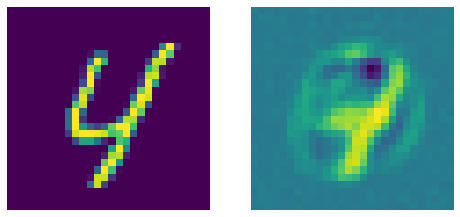

epoch: 1, step: 0, loss: 0.1679367870092392
epoch: 1, step: 200, loss: 0.13848444819450378
epoch: 1, step: 400, loss: 0.13596108555793762


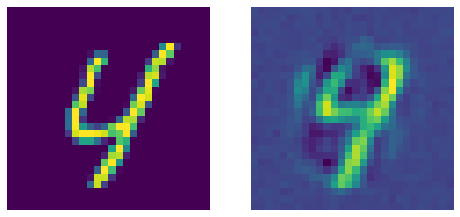

epoch: 2, step: 0, loss: 0.13407467305660248
epoch: 2, step: 200, loss: 0.12072227895259857
epoch: 2, step: 400, loss: 0.11795506626367569


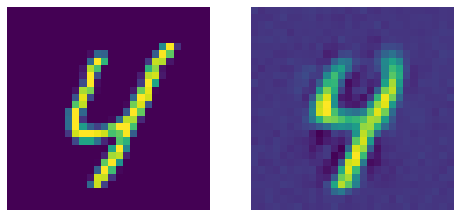

In [12]:
# hidden_out = 40
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        target = inputs.view(inputs.size(0), -1).to(device)
        predict = model(target)
        loss = loss_func(target, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test.data[555].unsqueeze(0).view(1, -1).to(device).float()
    show_img(
        dataset_test.data[555].detach().numpy(),
        model(item).view((28, 28)).cpu().detach().numpy()
    )
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')


In [26]:
input_channels = 1
hidden_channels = 64

In [27]:
# Changes:
# * в encoder заменил conv2 + pool2 на сверточный слой со сжатием фичмапы в 2 раза
# * в decoder заменил conv2 + upsample на сверточный слой ConvTranspose2d с разжатием фичмапы в 2 раза
# * во все внутренние слои добавил batchNorm
# * убрал dropout (вроде как не советуют делать dropout в сверточных сетях)
# * поменял порядок применения conv и upsample
# * заменил MSE на MAE

class ConvEncoder(nn.Module):
  #28x28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2)
    self.pool1 = nn.MaxPool2d((2, 2)) # 14 x 14
    self.bn1 = nn.BatchNorm2d(hidden_ch)

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=4, stride=2, 
                           padding=1) # 7 x 7
    self.bn2 = nn.BatchNorm2d(hidden_ch)

    self.conv3 = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1)
    self.activ = nn.LeakyReLU()

  def forward(self, x):
    x = self.bn1(self.pool1(self.activ(self.conv1(x))))
    x = self.bn2(self.activ(self.conv2(x)))
    return self.conv3(x)

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1)
    self.bn1 = nn.BatchNorm2d(hidden_ch)

    self.conv2 = nn.ConvTranspose2d(hidden_ch, hidden_ch, kernel_size=4,
                                   stride=2, padding=1) # 14 x 14
    self.bn2 = nn.BatchNorm2d(hidden_ch)

    self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2)
    self.activ = nn.LeakyReLU()

  def forward(self, x):
    x = self.bn1(self.activ(self.conv1(x)))
    x = self.bn2(self.activ(self.conv2(x)))
    return self.conv3(self.upsample3(x))

class ConvAutoEncoder(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [28]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE


epoch: 0, step: 0, loss: 0.9307725429534912
epoch: 0, step: 200, loss: 0.13327307999134064
epoch: 0, step: 400, loss: 0.1185569316148758


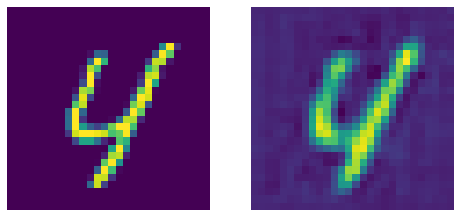

epoch: 1, step: 0, loss: 0.11039601266384125
epoch: 1, step: 200, loss: 0.10552534461021423
epoch: 1, step: 400, loss: 0.09809748083353043


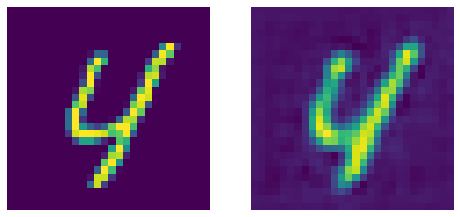

epoch: 2, step: 0, loss: 0.09949778020381927
epoch: 2, step: 200, loss: 0.08989826589822769
epoch: 2, step: 400, loss: 0.08560317009687424


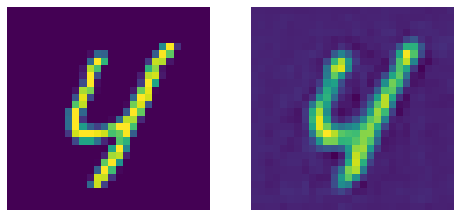

In [29]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model(inputs.to(device))
        loss = loss_func(inputs.to(device), predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    show_img(
        dataset_test[555][0].squeeze().detach().numpy(),
        model(item).squeeze().squeeze().cpu().detach().numpy()
    )
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

epoch: 0, step: 0, loss: 0.9597145318984985
epoch: 0, step: 200, loss: 0.14228211343288422
epoch: 0, step: 400, loss: 0.131911501288414


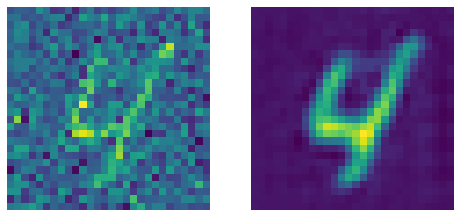

epoch: 1, step: 0, loss: 0.13612985610961914
epoch: 1, step: 200, loss: 0.11161461472511292
epoch: 1, step: 400, loss: 0.1108705997467041


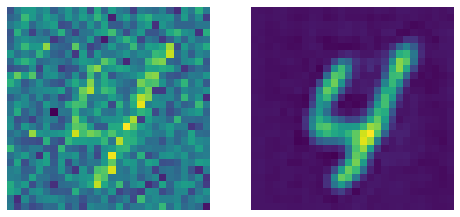

epoch: 2, step: 0, loss: 0.10971582680940628
epoch: 2, step: 200, loss: 0.09841583669185638
epoch: 2, step: 400, loss: 0.1111784279346466


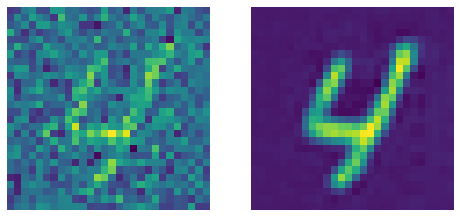

In [30]:
model = ConvAutoEncoder(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        noise_inputs = inputs + \
        torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict = model(noise_inputs)
        loss = loss_func(inputs, predict)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    show_img(
        item.squeeze().squeeze().cpu().detach().numpy(),
        model(item).squeeze().squeeze().cpu().detach().numpy()
    )
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

In [31]:
# Changes:
# * удалил dropOut
# * заменил активацию на leakyRelu
# * добавил batchNorm
# * в encoder заменил слой conv+pool на conv с уменьшением размера в 2 раза
# * в decoder заменил слой conv+upsample на convTranspose2d с увеличением размера в 2 раза

class ConvVAEncoder(nn.Module):
  #28*28 -> hidden -> hidden_out
  def __init__(self, input_ch, hidden_ch):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.pool1 = nn.MaxPool2d(2, 2) # 14x14
    self.bn1 = nn.BatchNorm2d(hidden_ch)

    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=4, stride=2, 
                           padding=1) # 7x7
    self.bn2 = nn.BatchNorm2d(hidden_ch)

    self.conv3_mu = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.conv3_sigma = nn.Conv2d(hidden_ch, 1, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.activ = nn.LeakyReLU()

  def forward(self, x):
    x = self.bn1(self.pool1(self.activ(self.conv1(x))))
    x = self.bn2(self.activ(self.conv2(x)))
    mu = self.conv3_mu(x)
    sigma = torch.exp(self.conv3_sigma(x))

    return mu, sigma

class ConvDecoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    #TODO try to use other layers
    self.conv1 = nn.Conv2d(1, hidden_ch, kernel_size=3, stride=1, 
                           padding=1) # 7x7
    self.bn1 = nn.BatchNorm2d(hidden_ch)

    self.conv2 = nn.ConvTranspose2d(hidden_ch, hidden_ch, kernel_size=4, stride=2, 
                           padding=1) # 14x14
    self.bn2 = nn.BatchNorm2d(hidden_ch)

    self.upsample3 = nn.UpsamplingNearest2d(scale_factor=2) # 28x28
    self.conv3 = nn.Conv2d(hidden_ch, input_ch, kernel_size=5, stride=1, 
                           padding=2) # 28x28
    self.activ = nn.LeakyReLU()
  def forward(self, x):
    x = self.bn1(self.activ(self.conv1(x)))
    x = self.bn2(self.activ(self.conv2(x)))
    x = self.conv3(self.upsample3(x))

    return x

def sampling(mu, sigma):
    return torch.normal(torch.zeros_like(mu), torch.ones_like(mu)) * sigma + mu

class ConvVAE(nn.Module):
  def __init__(self, input_ch, hidden_ch, ):
    super().__init__()
    self.encoder = ConvVAEncoder(input_ch, hidden_ch, )
    self.decoder = ConvDecoder(input_ch, hidden_ch, )

  def forward(self, x):
    mu, sigma = self.encoder(x)
    hidden = sampling(mu, sigma)
    x_ = self.decoder(hidden)

    return x_, mu, sigma

epoch: 0, step: 0, loss: 0.9688360691070557
epoch: 0, step: 200, loss: 0.14967019855976105
epoch: 0, step: 400, loss: 0.1354934424161911


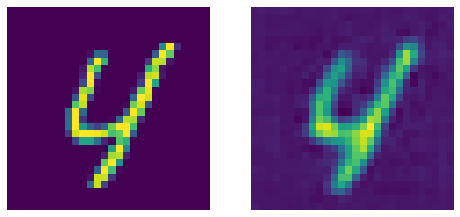

epoch: 1, step: 0, loss: 0.12394426017999649
epoch: 1, step: 200, loss: 0.12707608938217163
epoch: 1, step: 400, loss: 0.10963523387908936


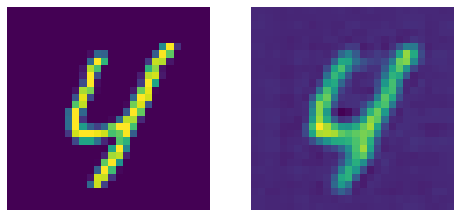

epoch: 2, step: 0, loss: 0.11591149866580963
epoch: 2, step: 200, loss: 0.11319278180599213
epoch: 2, step: 400, loss: 0.10962826758623123


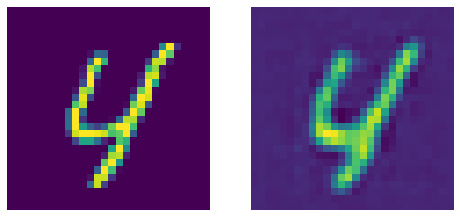

In [35]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
    return torch.distributions.kl_divergence(p, q).mean()

model = ConvVAE(input_channels, hidden_channels).to(device)
optim = torch.optim.Adam(model.parameters())
loss_func = nn.L1Loss() #TODO try to use MAE

for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()
        inputs = inputs.to(device)
        # noise_inputs = inputs + \
        # torch.normal(torch.zeros_like(inputs), torch.ones_like(inputs)) * 0.7 
        predict, mu, sigma = model(inputs)
        loss = loss_func(inputs, predict) + 0.01 * kl_loss(mu, sigma)
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    item = dataset_test[555][0].unsqueeze(0).to(device).float()
    # item = item + torch.normal(torch.zeros_like(item), torch.ones_like(item)) * 0.7
    show_img(
        item.squeeze().squeeze().cpu().detach().numpy(),
        model(item)[0].squeeze().squeeze().cpu().detach().numpy()
    )
    torch.save(model.state_dict(), f'./lin_ae_chkpt_{epoch}.pth')

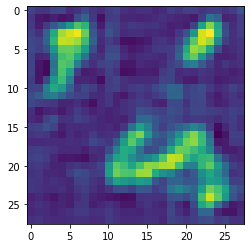

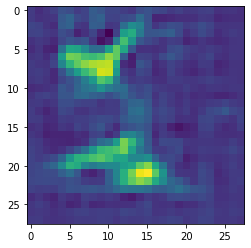

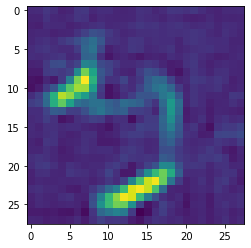

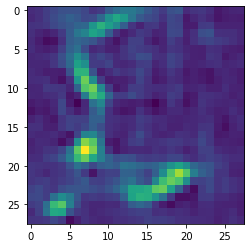

In [34]:
item = dataset_test[555][0].unsqueeze(0).to(device).float()
mu, sigma = model.encoder(item)

for _ in range(4):
    hid = torch.normal(torch.zeros((1,1,7,7)), torch.ones((1,1,7,7))).to(device) 

    plt.imshow(model.decoder(hid).squeeze().squeeze().cpu().detach().numpy())
    plt.show()